In [11]:
%pwd  #look at the current work dir
%cd  /eris/u/jschubert/optimism_transformer/
import sys
import pandas as pd
sys.path.append('src')
sys.path.append('analysis')
import sys
import pandas as pd
import seaborn as sns


/eris/u/jschubert/optimism_transformer


setup the data frame columns correctly with switch actions

In [67]:
path = '/u/jschubert/optimism_transformer/palminteri/simulation_humans.csv'
df = pd.read_csv(path)

# number block_idx correctly
max_trials = df.trials_idx.max()+1
df['block_idx'] = (df['session_number']-1) * 4 + df['block_idx']
df.drop('Unnamed: 0', axis=1, inplace=True)

# Plot - Proportion of correct choices

## First / second half

group low / high reward trials based on trial_idx 

In [56]:
# set optimal choice
df['optimal_choice'] = 1 - df['actions']

# select free and forced blocks and only free cues
free = df[(df['block_forced_type'] == 0) & (df['cues'] == 0)]
forced = df[(df['block_forced_type'] == 1) & (df['cues'] == 0)]


free_low = free[free.trials_idx <= 19]
free_high = free[free.trials_idx >= 20]
forced_low = forced[(forced.trials_idx <= 39)]
forced_high = forced[forced.trials_idx >= 40]


# optimal_choice = 1 - action
free_low_opt = free_low.groupby('test_eps_idx').mean()['optimal_choice']
free_high_opt = free_high.groupby('test_eps_idx').mean()['optimal_choice']
forced_low_opt = forced_low.groupby('test_eps_idx').mean()['optimal_choice']
forced_high_opt = forced_high.groupby('test_eps_idx').mean()['optimal_choice']

free_list = [free_low_opt, free_high_opt]
forced_list = [forced_low_opt, forced_high_opt]

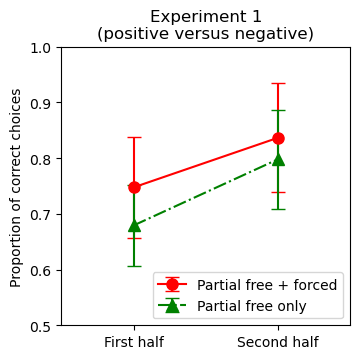

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Data
x_labels = ['First half', 'Second half']
x = [0, 1]

# Data for 'Partial free + forced'
y1_data = forced_list
y1_means = [np.mean(data) for data in y1_data]
y1_stds = [np.std(data) / np.sqrt(len(forced_list)) for data in y1_data]

# Data for 'Partial free only'
y2_data = free_list
y2_means = [np.mean(data) for data in y2_data]
y2_stds = [np.std(data) / np.sqrt(len(free_list)) for data in y2_data]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(3.7,3.7))

# Plot the data with error bars
ax.errorbar(x, y1_means, yerr=y1_stds, fmt='o-', label='Partial free + forced', markersize=8, color='red', capsize=5)
ax.errorbar(x, y2_means, yerr=y2_stds, fmt='^-.', label='Partial free only', markersize=8, color='green', capsize=5)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylim(0.5, 1)
ax.set_ylabel('Proportion of correct choices')
ax.set_title('Experiment 1\n(positive versus negative)')
ax.legend(loc='lower right')

ax.set_xlim(-0.5,1.5)

# Display the plot
plt.tight_layout()
plt.show()

## Whole Trial

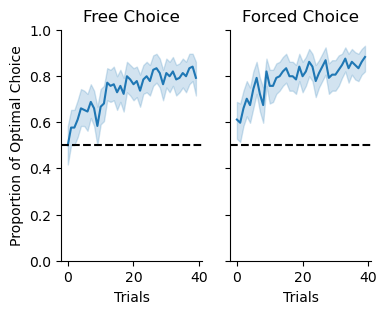

In [55]:
fig, axs = plt.subplots(1,2, figsize=(4, 3), sharey=True)

sns.lineplot(x='trials_idx', y='optimal_choice', data=free, ax=axs[0])
axs[0].set_title('Free Choice')
axs[0].set_xlabel('Trials')


axs[0].set_ylim(0.0,1)

# create a correct plot index for forced choices 
# as we have 80 trials intermixed with 40 forced and 40 free
forced_plot = forced.copy()
forced_plot['idx'] = np.tile(np.arange(0, 40), 24*3*2)

sns.lineplot(x='idx', y='optimal_choice', data=forced_plot, ax=axs[1])
axs[1].set_title('Forced Choice')
axs[1].set_xlabel('Trials')
axs[0].set_ylabel('Proportion of Optimal Choice')


axs[0].axhline(y=0.5, color='black', linestyle='--')
axs[1].axhline(y=0.5, color='black', linestyle='--')

sns.despine()

# Plot - Positive / Negative reward choice switches

In [72]:
# choice switches between trial t and t − 1 
# as a function of the obtained outcome seen on trial t − 1
# depending on whether this trial was a free- or a forced-choice trial

# shift the actions by 1 to the front to have prev_actions column
neg_rew_switch = (df['actions'] != df['actions'].shift(1)) & \
        (df['rewards'].shift(1) == -1.0) & \
         ~(df['trials_idx'] == df['trials_idx'].min())

pos_rew_switch = (df['actions'] != df['actions'].shift(1)) & \
        (df['rewards'].shift(1) == 1.0) & \
         ~(df['trials_idx'] == df['trials_idx'].min())

df['pos_rew_switch'] = pos_rew_switch
df['neg_rew_switch'] = neg_rew_switch

# select all prev. cues (free vs forced) and respective rewards from previous trial
# calculate the pos/neg rew switch probs

# in free block, select previous free cues and respective rewards and actions
free_pos_sw = df[(df['block_forced_type'] == 0) & (df['cues'].shift(1) == 0) & (df['rewards'].shift(1) == 1)].groupby('test_eps_idx').mean()['pos_rew_switch']
free_neg_sw = df[(df['block_forced_type'] == 0) & (df['cues'].shift(1) == 0) & (df['rewards'].shift(1) == -1)].groupby('test_eps_idx').mean()['neg_rew_switch']

# in forced block, select previous forced cues and respective rewards and actions where current cue is free
forced_pos_sw = df[(df['block_forced_type'] == 1) & (df['cues'].shift(1) > 0) & (df['rewards'].shift(1) == 1) & (df['cues'] == 0)].groupby('test_eps_idx').mean()['pos_rew_switch']
forced_neg_sw = df[(df['block_forced_type'] == 1) & (df['cues'].shift(1) > 0) & (df['rewards'].shift(1) == -1) & (df['cues'] == 0)].groupby('test_eps_idx').mean()['neg_rew_switch']

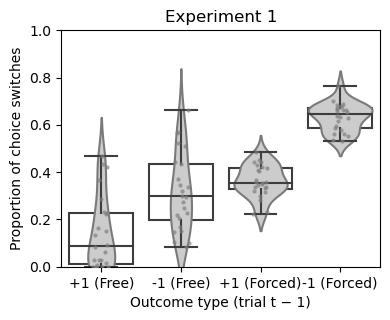

In [73]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Four categories for 'Outcome type (trial t − 1)'
categories = ['+1 (Free)', '-1 (Free)', '+1 (Forced)', '-1 (Forced)']

# Generating random data for the violin plot
data = [free_pos_sw, free_neg_sw, forced_pos_sw, forced_neg_sw]

# Combining data into a DataFrame
import pandas as pd
df_plt = pd.DataFrame({cat: values for cat, values in zip(categories, data)})
df_melted = df_plt.melt()

# Create the plot
plt.figure(figsize=(4,3.3))
sns.violinplot(x="variable", y="value", data=df_melted, inner=None, color=".8")
ax = sns.stripplot(x="variable", y="value", data=df_melted, jitter=True, marker='o', alpha=0.7, size=3, facecolor='grey')
sns.boxplot(x="variable", y="value", data=df_melted, boxprops={'facecolor':'None'})

# Customize the plot
plt.ylabel('Proportion of choice switches')
plt.xlabel('Outcome type (trial t − 1)')
plt.title('Experiment 1')
plt.ylim(0, 1)
plt.xticks([0, 1, 2, 3], categories)
plt.tight_layout()

plt.show()